In [1]:
# Projeto integrado da Pós-graduação Lato Sensu em Inteligência Artificial e Aprendizado de Máquina | Junho de 2023
# Aluno: Matheus Bonetto Balbino

In [2]:
#Importando as bibliotecas

#Bibliotecas de manipulação do python
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import pandas as pd
import tensorflow as tf
import math

#Biblioteca do Keras para construção da rede neural
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import GRU
from keras.optimizers import SGD


#Biblioteca sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

#Importação da biblioteca para obter os dados
import yfinance as yf

In [3]:
#Importando base de dados total
dataset = yf.download("ABEV3.SA", start='2019-01-02', end='2023-03-31', interval='1d')

#Base de treinamento
dataset_train = yf.download("ABEV3.SA", start='2019-01-02', end='2021-12-22', interval='1d')

#Base de teste
dataset_test = yf.download("ABEV3.SA", start='2021-12-23', end='2023-03-31', interval='1d')


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [4]:
# Calcula os retornos logarítmicos usando o preço de fechamento 
returns = np.log(dataset['Close'] / dataset['Close'].shift(1))
volatility = returns.std() * np.sqrt(252) 
sharpe_ratio = ((returns.mean()*252) - 0.1375) / volatility #Selic 13,75%
print("Sharpe Ratio - ABEV3: {:.2f}".format(sharpe_ratio))

Sharpe Ratio - ABEV3: -0.48


In [5]:
#Aplicando a rede neural GRU

In [6]:
#Obtendo a coluna Close da base de treinamento e teste
training_set = dataset_train.iloc[:, 3:4].values 
real_stock_price = dataset_test.iloc[:, 3:4].values

In [7]:
#Normalizando
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)

In [8]:
#Criando uma estrutura de dados
X_train = []
y_train = []
for i in range(60, 737):
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

In [9]:
#Remodelando
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [10]:
#Inicializando a rede RNN
regressorGRU = Sequential()

In [11]:
#Adiocionando a primeira camada da GRU
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))

In [12]:
#Adicionando a segunda camada da GRU
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))

In [13]:
#Adicionando a terceira camada da GRU
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))

In [14]:
#Adicionando a quarta camada da GRU
regressorGRU.add(GRU(units=50, activation='tanh'))
regressorGRU.add(Dropout(0.2))

In [15]:
#Adicionando a camada de saída
regressorGRU.add(Dense(units = 1))

#Compilando a RNN
regressorGRU.compile(optimizer=SGD(learning_rate=0.01, decay=1e-7, momentum=0.9, nesterov=False), loss='mean_squared_error')

#Ajustando a RNN ao conjunto de treinamento
regressorGRU.fit(X_train, y_train, epochs=100, batch_size=32)

Epoch 1/100
22/22 [==============================] - 26s 183ms/step - loss: 0.0858
Epoch 2/100
22/22 [==============================] - 4s 163ms/step - loss: 0.0236
Epoch 3/100
22/22 [==============================] - 4s 176ms/step - loss: 0.0097
Epoch 4/100
22/22 [==============================] - 4s 192ms/step - loss: 0.0091
Epoch 5/100
22/22 [==============================] - 5s 219ms/step - loss: 0.0079
Epoch 6/100
22/22 [==============================] - 5s 221ms/step - loss: 0.0081
Epoch 7/100
22/22 [==============================] - 5s 234ms/step - loss: 0.0073
Epoch 8/100
22/22 [==============================] - 4s 195ms/step - loss: 0.0071
Epoch 9/100
22/22 [==============================] - 4s 196ms/step - loss: 0.0066
Epoch 10/100
22/22 [==============================] - 4s 176ms/step - loss: 0.0069
Epoch 11/100
22/22 [==============================] - 5s 210ms/step - loss: 0.0068
Epoch 12/100
22/22 [==============================] - 4s 199ms/step - loss: 0.0064
Epoch 13/100

In [16]:
#Resumo do modelo
print(regressorGRU.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 60, 50)            7950      
                                                                 
 dropout (Dropout)           (None, 60, 50)            0         
                                                                 
 gru_1 (GRU)                 (None, 60, 50)            15300     
                                                                 
 dropout_1 (Dropout)         (None, 60, 50)            0         
                                                                 
 gru_2 (GRU)                 (None, 60, 50)            15300     
                                                                 
 dropout_2 (Dropout)         (None, 60, 50)            0         
                                                                 
 gru_3 (GRU)                 (None, 50)                1

In [17]:
#Realizando as previsões

In [18]:
dataset_total = dataset['Close']

In [19]:
dataset_total.head()

Date
2019-01-02    16.150000
2019-01-03    16.330000
2019-01-04    16.549999
2019-01-07    16.480000
2019-01-08    16.150000
Name: Close, dtype: float64

In [20]:
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60:].values

In [21]:
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []

In [22]:
#O segundo número é o len(inputs)
for i in range(60, 377): 
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_stock_price = regressorGRU.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

10/10 [==============================] - 6s 137ms/step


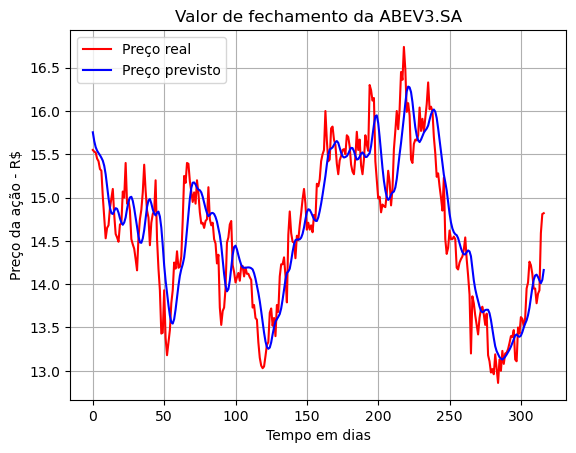

In [23]:
plt.plot(real_stock_price, color = 'red', label = 'Preço real')
plt.plot(predicted_stock_price, color = 'blue', label = 'Preço previsto')
plt.title('Valor de fechamento da ABEV3.SA')
plt.xlabel('Tempo em dias')
plt.ylabel('Preço da ação - R$')
plt.legend()
plt.grid()
plt.show()

In [24]:
#Criando dataset único

#Criando a coluna data
dataset_test_graf = dataset_test.reset_index() #Criando um index

In [25]:
print(dataset_test_graf)

          Date   Open   High    Low  Close  Adj Close     Volume
0   2021-12-23  15.40  15.67  15.34  15.55  14.771684   10634700
1   2021-12-27  15.55  15.65  15.48  15.53  14.752684    8437200
2   2021-12-28  15.54  15.57  15.40  15.52  14.743185    7701300
3   2021-12-29  15.55  15.56  15.34  15.45  14.676688    8847300
4   2021-12-30  15.58  15.59  15.39  15.42  14.648190   11819300
..         ...    ...    ...    ...    ...        ...        ...
312 2023-03-24  13.84  14.02  13.75  13.89  13.890000   27154200
313 2023-03-27  14.00  14.11  13.88  13.93  13.930000   15709700
314 2023-03-28  13.95  15.03  13.90  14.59  14.590000  121741000
315 2023-03-29  14.66  14.92  14.49  14.81  14.810000   40734700
316 2023-03-30  15.00  15.05  14.75  14.82  14.820000   24247000

[317 rows x 7 columns]


In [26]:
real_stock_price_date = dataset_test_graf['Date'] #Criando um dataset com a coluna Date

In [27]:
print(real_stock_price_date)

0     2021-12-23
1     2021-12-27
2     2021-12-28
3     2021-12-29
4     2021-12-30
         ...    
312   2023-03-24
313   2023-03-27
314   2023-03-28
315   2023-03-29
316   2023-03-30
Name: Date, Length: 317, dtype: datetime64[ns]


In [28]:
real_stock_price_date = pd.DataFrame(real_stock_price_date, columns = ['Date']) #Incluindo a linha com o nome Date

In [29]:
real_stock_price_date.head()

,Date
0,2021-12-23
1,2021-12-27
2,2021-12-28
3,2021-12-29
4,2021-12-30


In [30]:
real_stock_price_close = dataset_test_graf['Close'] #Criando um dataset close real

In [31]:
print(real_stock_price_close)

0      15.55
1      15.53
2      15.52
3      15.45
4      15.42
       ...  
312    13.89
313    13.93
314    14.59
315    14.81
316    14.82
Name: Close, Length: 317, dtype: float64


In [32]:
real_stock_price_close_gra = pd.DataFrame(real_stock_price_close, columns = ['Close']) #Criando um dataset real

In [33]:
real_stock_price_close_gra.head()

,Close
0,15.55
1,15.53
2,15.52
3,15.45
4,15.42


In [34]:
predicted_stock_price_gra = pd.DataFrame(predicted_stock_price, columns = ['Predicted']) #Criando um dataset predicted

In [35]:
predicted_stock_price_gra.head()

,Predicted
0,15.754182
1,15.652234
2,15.583197
3,15.542010
4,15.514004


In [36]:
dataset_predicted=pd.concat([real_stock_price_date, real_stock_price_close_gra, predicted_stock_price_gra],axis=1,join='inner')

In [37]:
dataset_predicted.head()

,Date,Close,Predicted
0,2021-12-23,15.55,15.754182
1,2021-12-27,15.53,15.652234
2,2021-12-28,15.52,15.583197
3,2021-12-29,15.45,15.542010
4,2021-12-30,15.42,15.514004


In [38]:
dataset_predicted = dataset_predicted.set_index('Date')

In [39]:
dataset_predicted.tail(5)

,Close,Predicted
Date,,
2023-03-24,13.89,14.082594
2023-03-27,13.93,14.043365
2023-03-28,14.59,14.011834
2023-03-29,14.81,14.048987
2023-03-30,14.82,14.164171


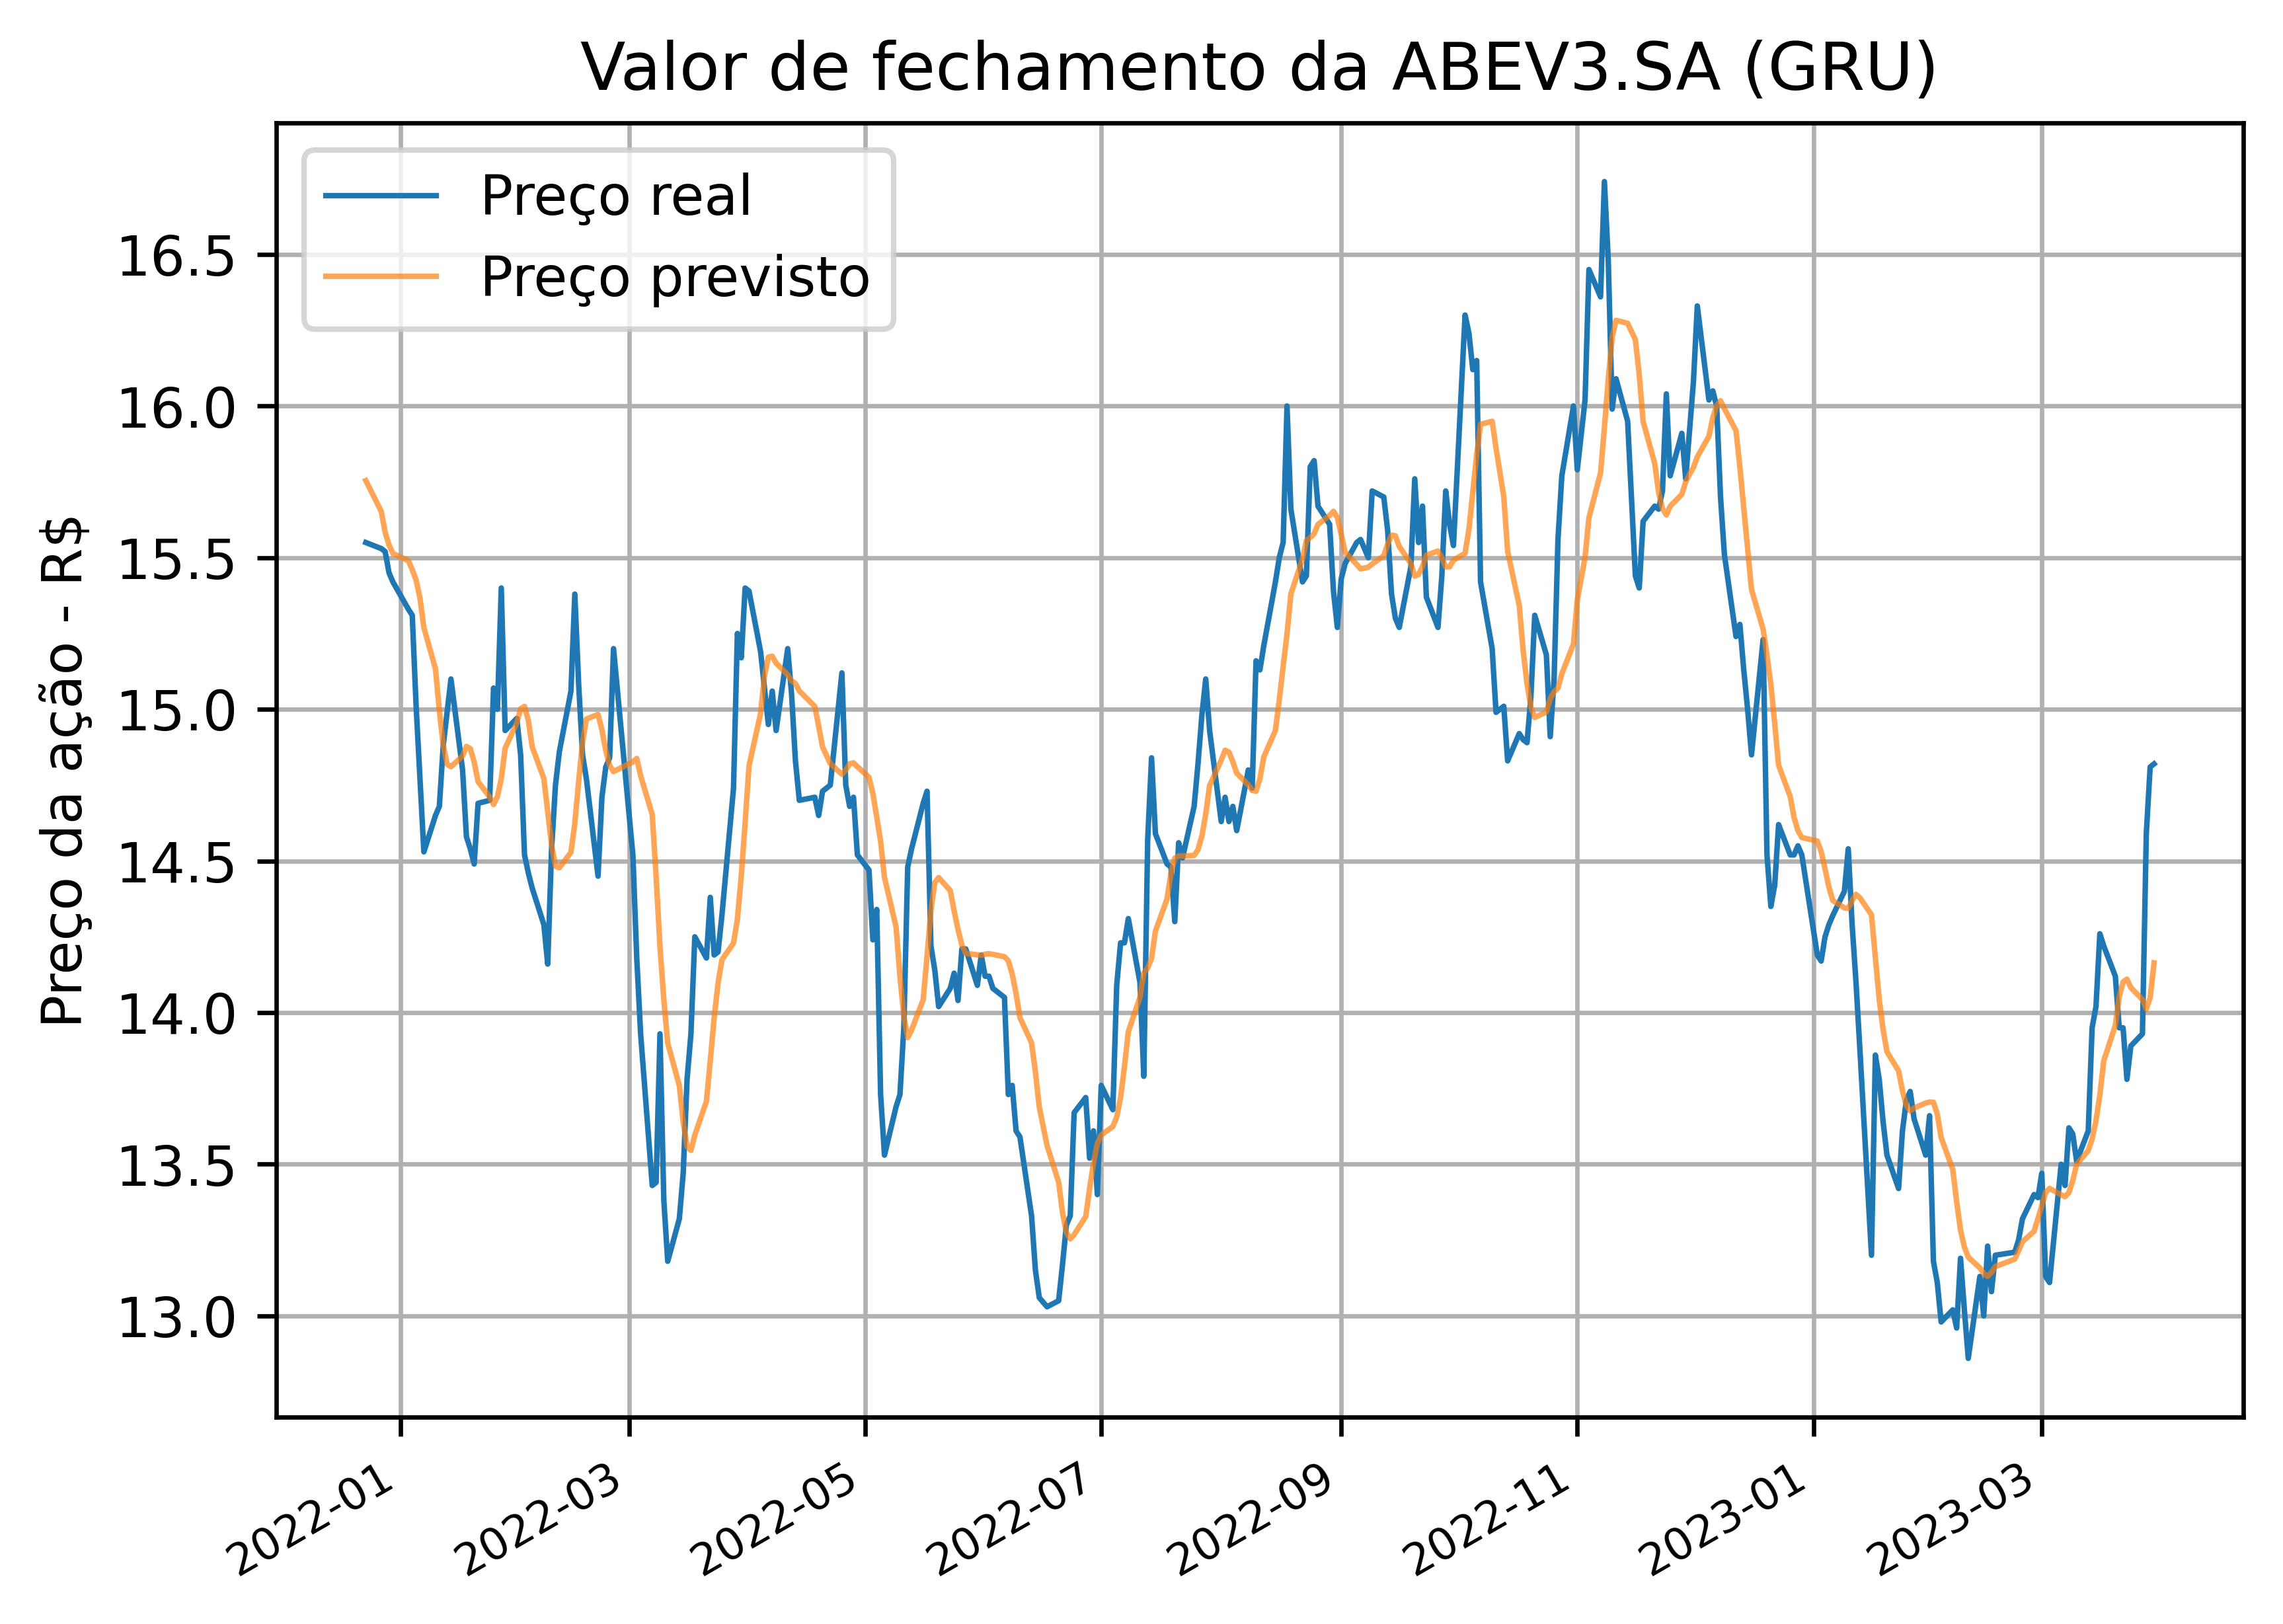

In [53]:
#Gráfico com as previsões
fig, ax = plt.subplots(dpi=600)
date_format = DateFormatter("%Y-%m")
ax.xaxis.set_major_formatter(date_format)
ax.tick_params(axis='x', labelsize=8)
fig.autofmt_xdate()

ax.plot(dataset_predicted['Close'], lw=1, label = 'Preço real')
ax.plot(dataset_predicted['Predicted'], lw=1, alpha=0.7, label='Preço previsto')

ax.set_ylabel('Preço da ação - R$')
ax.set_title('Valor de fechamento da ABEV3.SA (GRU)')
ax.grid() 
ax.legend()

plt.show()

In [41]:
#Métricas de avaliação

#Erro Médio Absoluto - MAE
MAE = mean_absolute_error(real_stock_price_close_gra, predicted_stock_price_gra)

In [42]:
#Erro Quadrático Médio - MSE
MSE = mean_squared_error(real_stock_price_close_gra, predicted_stock_price_gra, squared = True)

In [43]:
#Raiz quadrada do erro médio - RMSE
RMSE = mean_squared_error(real_stock_price_close_gra, predicted_stock_price_gra, squared = False)

In [44]:
#Média Percentual Absoluta do Erro - MAPE
MAPE = mean_absolute_percentage_error(real_stock_price_close_gra, predicted_stock_price_gra)

In [45]:
#Erro relativo
dataset_predicted['Error %'] = dataset_predicted.apply(lambda x: 100*(abs(x['Close']-x['Predicted'])/x['Close']), axis=1)

In [46]:
dataset_predicted.head()

,Close,Predicted,Error %
Date,,,
2021-12-23,15.55,15.754182,1.313065
2021-12-27,15.53,15.652234,0.787085
2021-12-28,15.52,15.583197,0.407192
2021-12-29,15.45,15.542010,0.595537
2021-12-30,15.42,15.514004,0.609622


In [47]:
Max = max(dataset_predicted['Error %'])

In [48]:
Min = min(dataset_predicted['Error %'])

In [49]:
print('Métricas de avaliação GRU - ABEV3:')
print("MAE: {:.3f}".format(MAE))
print("MAPE: {:.3f}%".format(MAPE*100))
print("RMSE: {:.3f}".format(RMSE))
print("MSE: {:.3f}".format(MSE))
print('Máximo erro relativo = {:.3f}%'.format(Max))
print('Mínimo erro relativo = {:.3f}%'.format(Min))

Métricas de avaliação GRU - ABEV3:
MAE: 0.304
MAPE: 2.086%
RMSE: 0.385
MSE: 0.149
Máximo erro relativo = 9.107%
Mínimo erro relativo = 0.005%


In [50]:
print('GRU - ABEV3')
dataset_predicted.describe()

GRU - ABEV3


,Close,Predicted,Error %
count,317.000000,317.000000,317.000000
mean,14.610946,14.654905,2.086118
std,0.859239,0.793182,1.643790
min,12.860000,13.130398,0.004859
25%,13.950000,14.050609,0.747682
50%,14.650000,14.748847,1.746123
75%,15.270000,15.360257,3.148817
max,16.740000,16.282526,9.106744


In [51]:
# Calcula os retornos logarítmicos usando o preço de fechamento 
returns = np.log(dataset_predicted['Close'] / dataset_predicted['Close'].shift(1))
volatility = returns.std() * np.sqrt(252) 
sharpe_ratio = ((returns.mean()*252) - 0.1375) / volatility #Selic 13,75%
print("Sharpe Ratio - ABEV3: {:.2f}".format(sharpe_ratio))

Sharpe Ratio - ABEV3: -0.70


In [52]:
# Calcula os retornos logarítmicos usando o preço de fechamento 
returns = np.log(dataset_predicted['Predicted'] / dataset_predicted['Predicted'].shift(1))
volatility = returns.std() * np.sqrt(252) 
sharpe_ratio = ((returns.mean()*252) - 0.1375) / volatility #Selic 13,75%
print("Sharpe Ratio - ABEV3: {:.2f}".format(sharpe_ratio))

Sharpe Ratio - ABEV3: -2.58


In [ ]:
#Fim